In [46]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data/gaze_positions.csv")

In [3]:
data.head()

,timestamp,index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center0_3d_z,gaze_normal0_x,gaze_normal0_y,gaze_normal0_z,eye_center1_3d_x,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z
0,2068.225736,0,0.650270,0.448057,0.264802,2068.225736-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2068.234136,0,0.742758,0.448100,0.266096,2068.234136-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2068.242536,0,0.718833,0.448159,0.267916,2068.242536-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2068.250936,0,0.580725,0.448509,0.269176,2068.250936-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2068.259336,0,0.621873,0.448495,0.270936,2068.259336-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
core = data[["timestamp", "confidence", "norm_pos_x", "norm_pos_y"]]

In [7]:
core.head()

,timestamp,confidence,norm_pos_x,norm_pos_y
0,2068.225736,0.650270,0.448057,0.264802
1,2068.234136,0.742758,0.448100,0.266096
2,2068.242536,0.718833,0.448159,0.267916
3,2068.250936,0.580725,0.448509,0.269176
4,2068.259336,0.621873,0.448495,0.270936


In [18]:
from matplotlib import pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


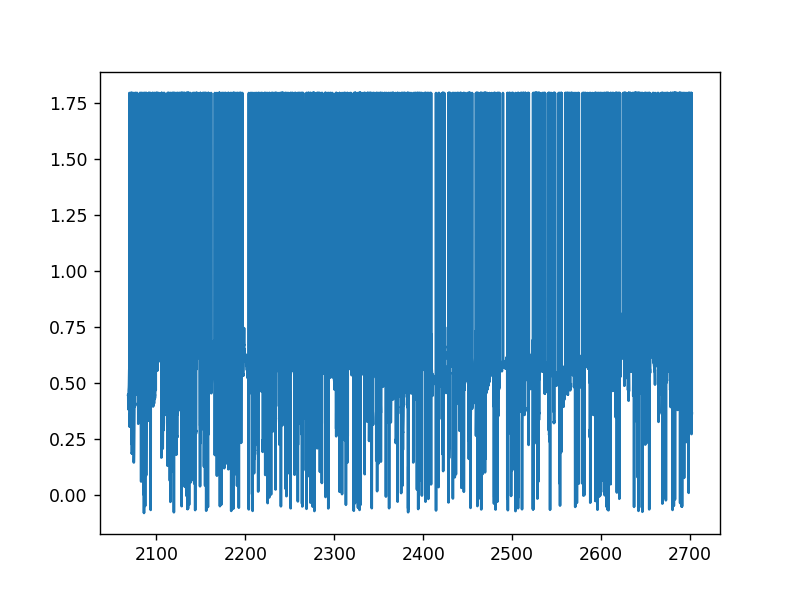

In [19]:
plt.figure()
plt.plot(data["timestamp"], data["norm_pos_x"])
plt.show()

<IPython.core.display.Javascript object>


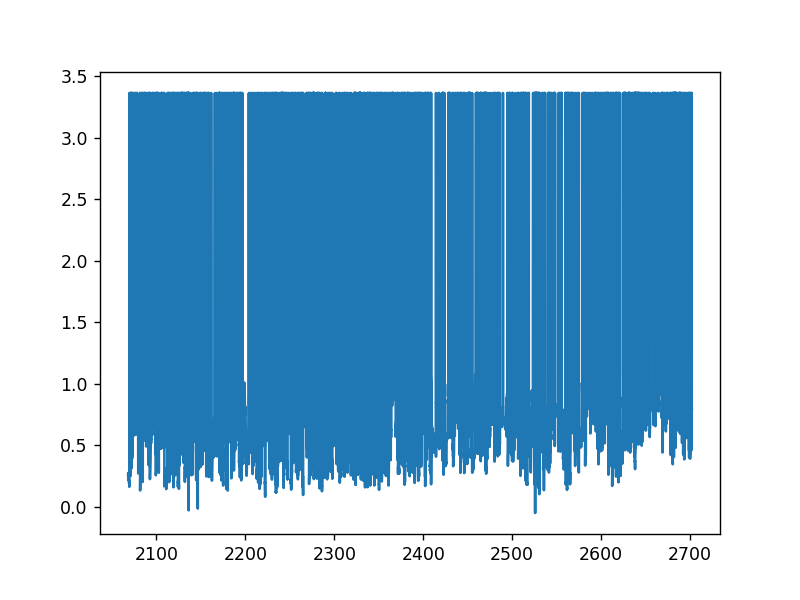

In [20]:
plt.figure()
plt.plot(data["timestamp"], data["norm_pos_y"])
plt.show()

<IPython.core.display.Javascript object>


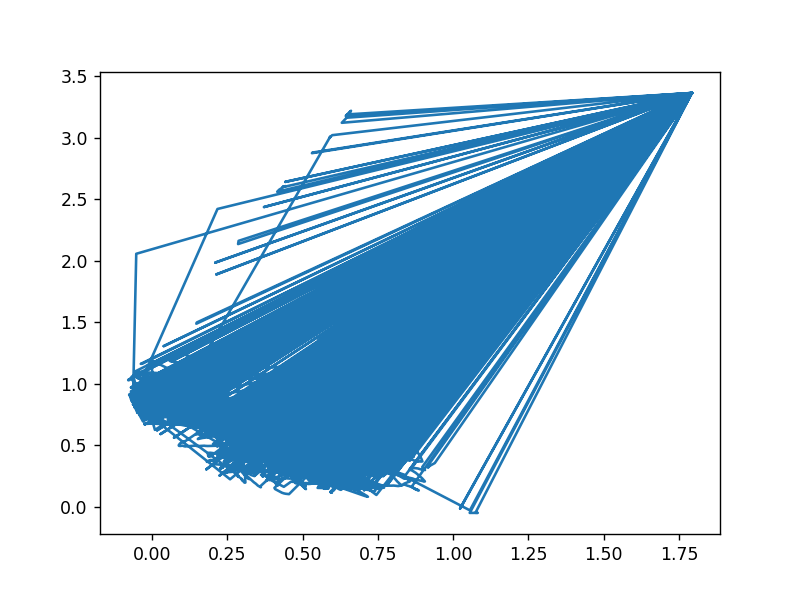

In [21]:
plt.figure()
plt.plot(data["norm_pos_x"], data["norm_pos_y"])
plt.show()

In [17]:
from mpl_toolkits import mplot3d

<IPython.core.display.Javascript object>


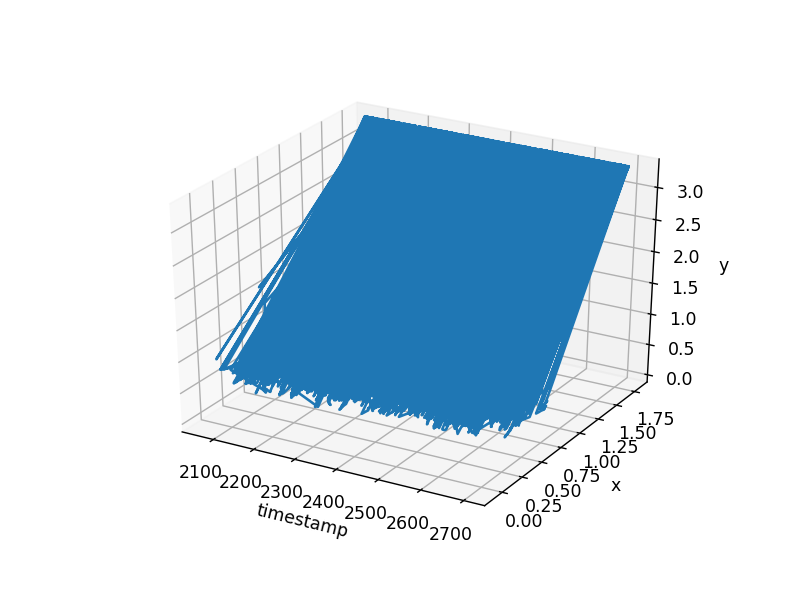

In [66]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(data["timestamp"], data["norm_pos_x"], data["norm_pos_y"])
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
plt.show()

In [30]:
from pykalman import KalmanFilter

In [81]:
kf = KalmanFilter(initial_state_mean=0.5, n_dim_obs=2)

In [94]:
xy = data[["norm_pos_x", "norm_pos_y"]].values

In [95]:
xy[1:10]

array([[0.44809971, 0.26609635],
       [0.448159  , 0.26791572],
       [0.44850883, 0.26917641],
       [0.44849496, 0.27093639],
       [0.44827076, 0.27285433],
       [0.44840316, 0.27538407],
       [0.44839952, 0.27528453],
       [0.44818918, 0.27641514],
       [0.38839063, 0.2171922 ]])

In [110]:
kf = KalmanFilter(initial_state_mean=[1,1.5],n_dim_obs=2)
output = kf.em(xy[:1000]).smooth(xy[:1000])

In [130]:
xy_new = output[0]
x = xy_new[:,0]
y = xy_new[:,1]

In [111]:
ts = data["timestamp"].values[:1000]

In [113]:
ts.shape

(1000,)

<IPython.core.display.Javascript object>


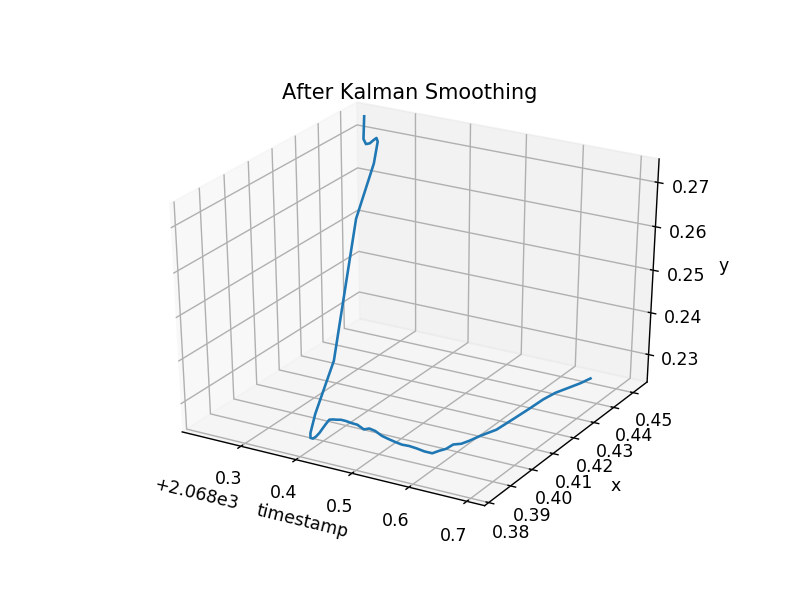

In [135]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')
ax.plot3D(ts[0:50],x[0:50],y[0:50])
# ax.plot3D(ts[0:50],data["norm_pos_x"][0:50], data["norm_pos_y"][0:50])
ax.set_xlabel('timestamp')
ax.set_ylabel('x')
ax.set_zlabel('y');
# ax.set_title("Observed Values")
ax.set_title("After Kalman Smoothing")
plt.show()
plt.savefig("kalman.png")